# Analisis Sentimen dan Prediksi dengan Random Forest pada Data Debat Capres Kedua dari Channel Najwa Shihab

Eros Alfedo Hermanto (2108096006) <br>
Insanu Sholeh Jum Gunawan (2108096032)

## 1. Instalasi Library

Kode ini menginstal beberapa paket Python yang diperlukan untuk menjalankan skrip, seperti transformers untuk tugas pemrosesan bahasa alami, googletrans untuk mentranslasi teks, fuzzywuzzy untuk mencari kesamaan antara dua string, dan sastrawi untuk memproses teks bahasa Indonesia.

In [1]:
!pip install transformers

In [2]:
!pip install googletrans==3.1.0a0

In [3]:
!pip install fuzzywuzzy

In [4]:
!pip install sastrawi

In [5]:
!pip install fuzzywuzzy

## 2. Import Library dan Load Data

Pada bagian ini, kode melakukan import library yang diperlukan dan memuat data komentar YouTube dari file CSV.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [7]:
data_path = "youtube_comments.csv"

In [8]:
data = pd.read_csv(data_path)

In [9]:
data

,author,published_at,updated_at,like_count,text
0,@user-wl4ji6hv4u,2024-03-05T05:03:40Z,2024-03-05T05:03:40Z,0.0,all in 02
1,@mustafashaleh4150,2024-02-20T01:57:28Z,2024-02-20T01:57:28Z,3.0,"<a href=""https://www.youtube.com/watch?v=Sbjsg..."
2,@IseanwarsadadAmangzian-rw9xe,2024-02-18T18:33:16Z,2024-02-18T18:33:16Z,0.0,P Prabowo p Ganjar jadikan Mentri pertahanan p...
3,@bobamochi2679,2024-02-18T08:22:49Z,2024-02-18T08:22:49Z,0.0,Love Pak Anies!
4,@lizaherlambang1811,2024-02-13T23:22:57Z,2024-02-13T23:22:57Z,3.0,Wong pertahanan negara kok disuruh terbuka utk...
...,...,...,...,...,...
4740,@haikalhyakuya,2024-01-07T16:01:51Z,2024-01-07T16:01:51Z,13.0,Debat kedua Capres ini seruu bangetttt🔥🔥🔥🔥
4741,@andijaelanichannel6163,2024-01-07T16:01:50Z,2024-01-07T16:01:50Z,0.0,Bismillah 😊
4742,@ilhambudiaraya1257,2024-01-07T16:01:41Z,2024-01-07T16:01:41Z,4.0,2
4743,@LangkahMudah,2024-01-07T16:01:35Z,2024-01-07T16:01:35Z,17.0,"1 FOREVER, 2-3 no more...!!! AM1N!!!"


## 3. Preprocessing dan Translasi Text

Bagian ini mentranslasi teks komentar dari bahasa Indonesia ke bahasa Inggris menggunakan googletrans. Sebelum ditranslasi, teks dibersihkan dari karakter non-alfanumerik dan URL menggunakan fungsi clean_tweet.

In [10]:
# Inisialisasi translator dan sentiment classifier
from googletrans import Translator
translator = Translator()

from transformers import pipeline
sentiment_classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [11]:
# # Fungsi untuk membersihkan teks
def clean_tweet(tweet):
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [12]:
# # Mentranslasi teks ke bahasa Inggris dan membersihkan teks
data['label'] = data["text"].str.encode('ascii','ignore').apply(translator.translate, dest='en')
data['label'] = data["label"].apply(getattr, args=('text',))
data['label'] = data.apply(lambda x: clean_tweet(x['label']), axis=1)

In [13]:
data.sample(20)

,author,published_at,updated_at,like_count,text,label
3708,@SixseveneightProject-ob4rj,2024-01-07T18:35:13Z,2024-01-07T18:35:13Z,2.0,02,b 02
1239,@V_chan,2024-01-08T16:10:58Z,2024-01-08T16:10:58Z,0.0,"<a href=""https://www.youtube.com/watch?v=Sbjsg...",b a href not my choice but I agree with his words
4092,@vividquatricia4902,2024-01-07T17:36:21Z,2024-01-07T17:36:21Z,128.0,"Debat yg seru ,Pak Ganjar mengejutkan,Pak Anie...",b Exciting debate Mr Ganjar surprised Mr Anies...
3523,@webiwidianti4632,2024-01-07T19:22:52Z,2024-01-07T19:22:52Z,0.0,Kenapa gk ada yg membicarakan kesejahtraan mas...,Why isn t anyone talking about the welfare of ...
1688,@andungnext7223,2024-01-08T11:12:16Z,2024-01-08T11:12:16Z,0.0,Setujuu terbuka di mata najwa maap saya spam 10 x,Agree open in Najwa s eyes sorry I spam 10 x
3107,@enisititurmiasih8003,2024-01-07T22:41:45Z,2024-01-07T22:41:45Z,0.0,Anies rasyid baswedan.....❤,b Anies rasyid baswedan
1537,@alifatunfajarnurhasanah5190,2024-01-08T13:16:47Z,2024-01-08T13:16:47Z,1.0,"11/100 = 1,1 ❌ <br>11/100 = 0,11 ✅",b 11 100 1 1 br 11 100 0 11
3653,@yourmusicfeelit,2024-01-07T18:47:15Z,2024-01-07T18:47:15Z,0.0,"lets go mba nana, ruang terbuka 3 capres. yuk ...",Let s go Miss Nana there are 3 presidential ca...
2757,@bethariakristine7353,2024-01-08T01:05:34Z,2024-01-08T01:05:34Z,1.0,Ayo dong beneran di mata najwaaa,Come on be real in Najwa s eyes
74,@DaunOfficial,2024-01-15T01:03:27Z,2024-01-15T01:03:27Z,0.0,Ambisi pribadi = pak wowo 1x cawapres 3x capres,b Personal ambition sir wowo 1x cawapres 3x pr...


## 4. Analisis Sentimen dengan Vader

Kode ini menggunakan library VADER (Valence Aware Dictionary and sEntiment Reasoner) untuk melakukan analisis sentimen pada teks yang telah ditranslasi. Fungsi get_sentiment_vader mengklasifikasikan teks menjadi 'positif', 'negatif', atau 'netral' berdasarkan skor sentimen yang dihitung oleh VADER.

In [14]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Inisialisasi SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Fungsi untuk mengklasifikasikan sentimen menggunakan VADER
def get_sentiment_vader(label):
    # Cek jika label adalah string
    if isinstance(label, str):
        sentiment_score = sia.polarity_scores(label)
        if sentiment_score['compound'] > 0.05:
            return 'positive'
        elif sentiment_score['compound'] < -0.05:
            return 'negative'
    # Jika label bukan string, kembalikan 'neutral'
    return 'neutral'

# Mengaplikasikan fungsi ke kolom 'label' dalam dataset Anda
data['sentiment'] = data['label'].apply(get_sentiment_vader)


In [17]:
data.sample(10)

,author,published_at,updated_at,like_count,text,label,sentiment
3705,@afforall1737,2024-01-07T18:35:41Z,2024-01-07T18:35:41Z,0.0,Berbicara fakta itu memang sakit karena demi k...,It s painful to talk about facts because it s ...,neutral
1860,@nobslayer5402,2024-01-08T08:34:26Z,2024-01-08T08:34:26Z,0.0,debat di mata najwa,b debate in Najwa s eyes,neutral
2557,@fushiawinter,2024-01-08T02:18:17Z,2024-01-08T02:18:17Z,0.0,pak prabowo uda ngga stabil dari jawabannya jd...,Pak Prabowo is no longer stable in his answers...,neutral
733,@sinestesia9547,2024-01-09T08:32:33Z,2024-01-09T08:32:33Z,2.0,Yang penting jangan PDIP lah,The important thing is not PDIP,positive
3793,@opposaabiq113,2024-01-07T18:21:39Z,2024-01-07T18:21:39Z,1.0,Sya mengharap ada debat Terbuka bebas buat 3 C...,b I hope there will be a free and open debate ...,positive
2949,@lintangwisesa,2024-01-07T23:58:10Z,2024-01-07T23:58:10Z,3.0,Saatnya Indonesia dipimpin oleh sosok yang cak...,b It s time for Indonesia to be led by a capab...,positive
4681,@habsieazzurri3344,2024-01-07T16:09:41Z,2024-01-07T16:09:41Z,16.0,Rakyat antah barantah seperti saya aja bisa ng...,b Even people in the middle of nowhere like me...,positive
424,@alfath1686,2024-01-10T02:01:57Z,2024-01-10T02:01:57Z,0.0,Salama yg jadi bintang tamu,b Salama who is a guest star,neutral
466,@ONNOTO-tv,2024-01-09T19:11:16Z,2024-01-09T19:11:16Z,2.0,Knapa ya pa anis lebih menyerang secara pribad...,Why is it that Mr Anies attacks personally ins...,negative
1672,@ridziefamz3625,2024-01-08T11:30:06Z,2024-01-08T11:30:06Z,2.0,Prabowo bukan emosi.. Tapi panik.. Dan Terteka...,b Prabowo is not emotional But panicked And de...,negative


## 5. Pemrosesan Data

Bagian ini melakukan pemrosesan data, seperti memeriksa adanya nilai yang hilang (null), menghapus baris yang memiliki nilai null, dan membuang baris yang memiliki teks kosong.

In [18]:
# Memeriksa apakah ada nilai null dalam dataset
print(data.isnull().values.any())

True


In [19]:
# Menghapus baris dengan nilai null
data.dropna(inplace=True)

# Menghapus baris dengan teks kosong
data = data[data['text'].apply(len)>1]

In [20]:
# # Menampilkan informasi dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4671 entries, 0 to 4744
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   author        4671 non-null   object 
 1   published_at  4671 non-null   object 
 2   updated_at    4671 non-null   object 
 3   like_count    4671 non-null   float64
 4   text          4671 non-null   object 
 5   label         4671 non-null   object 
 6   sentiment     4671 non-null   object 
dtypes: float64(1), object(6)
memory usage: 291.9+ KB


## 6. Visualisasi Data

Kode ini memvisualisasikan distribusi sentimen dalam data menggunakan pie chart dan wordcloud. Wordcloud dibuat untuk setiap kategori sentimen ('positif', 'negatif', dan 'netral') dengan menggunakan library wordcloud.

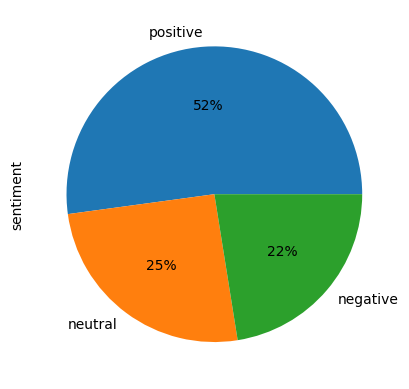

In [21]:
# Memvisualisasikan distribusi sentimen menggunakan pie chart
data['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

# Membuat wordcloud untuk setiap sentimen
stopwords = set(STOPWORDS)

In [22]:
sentiment_counts = data['sentiment'].value_counts()
print(sentiment_counts)

positive    2436
neutral     1185
negative    1050
Name: sentiment, dtype: int64


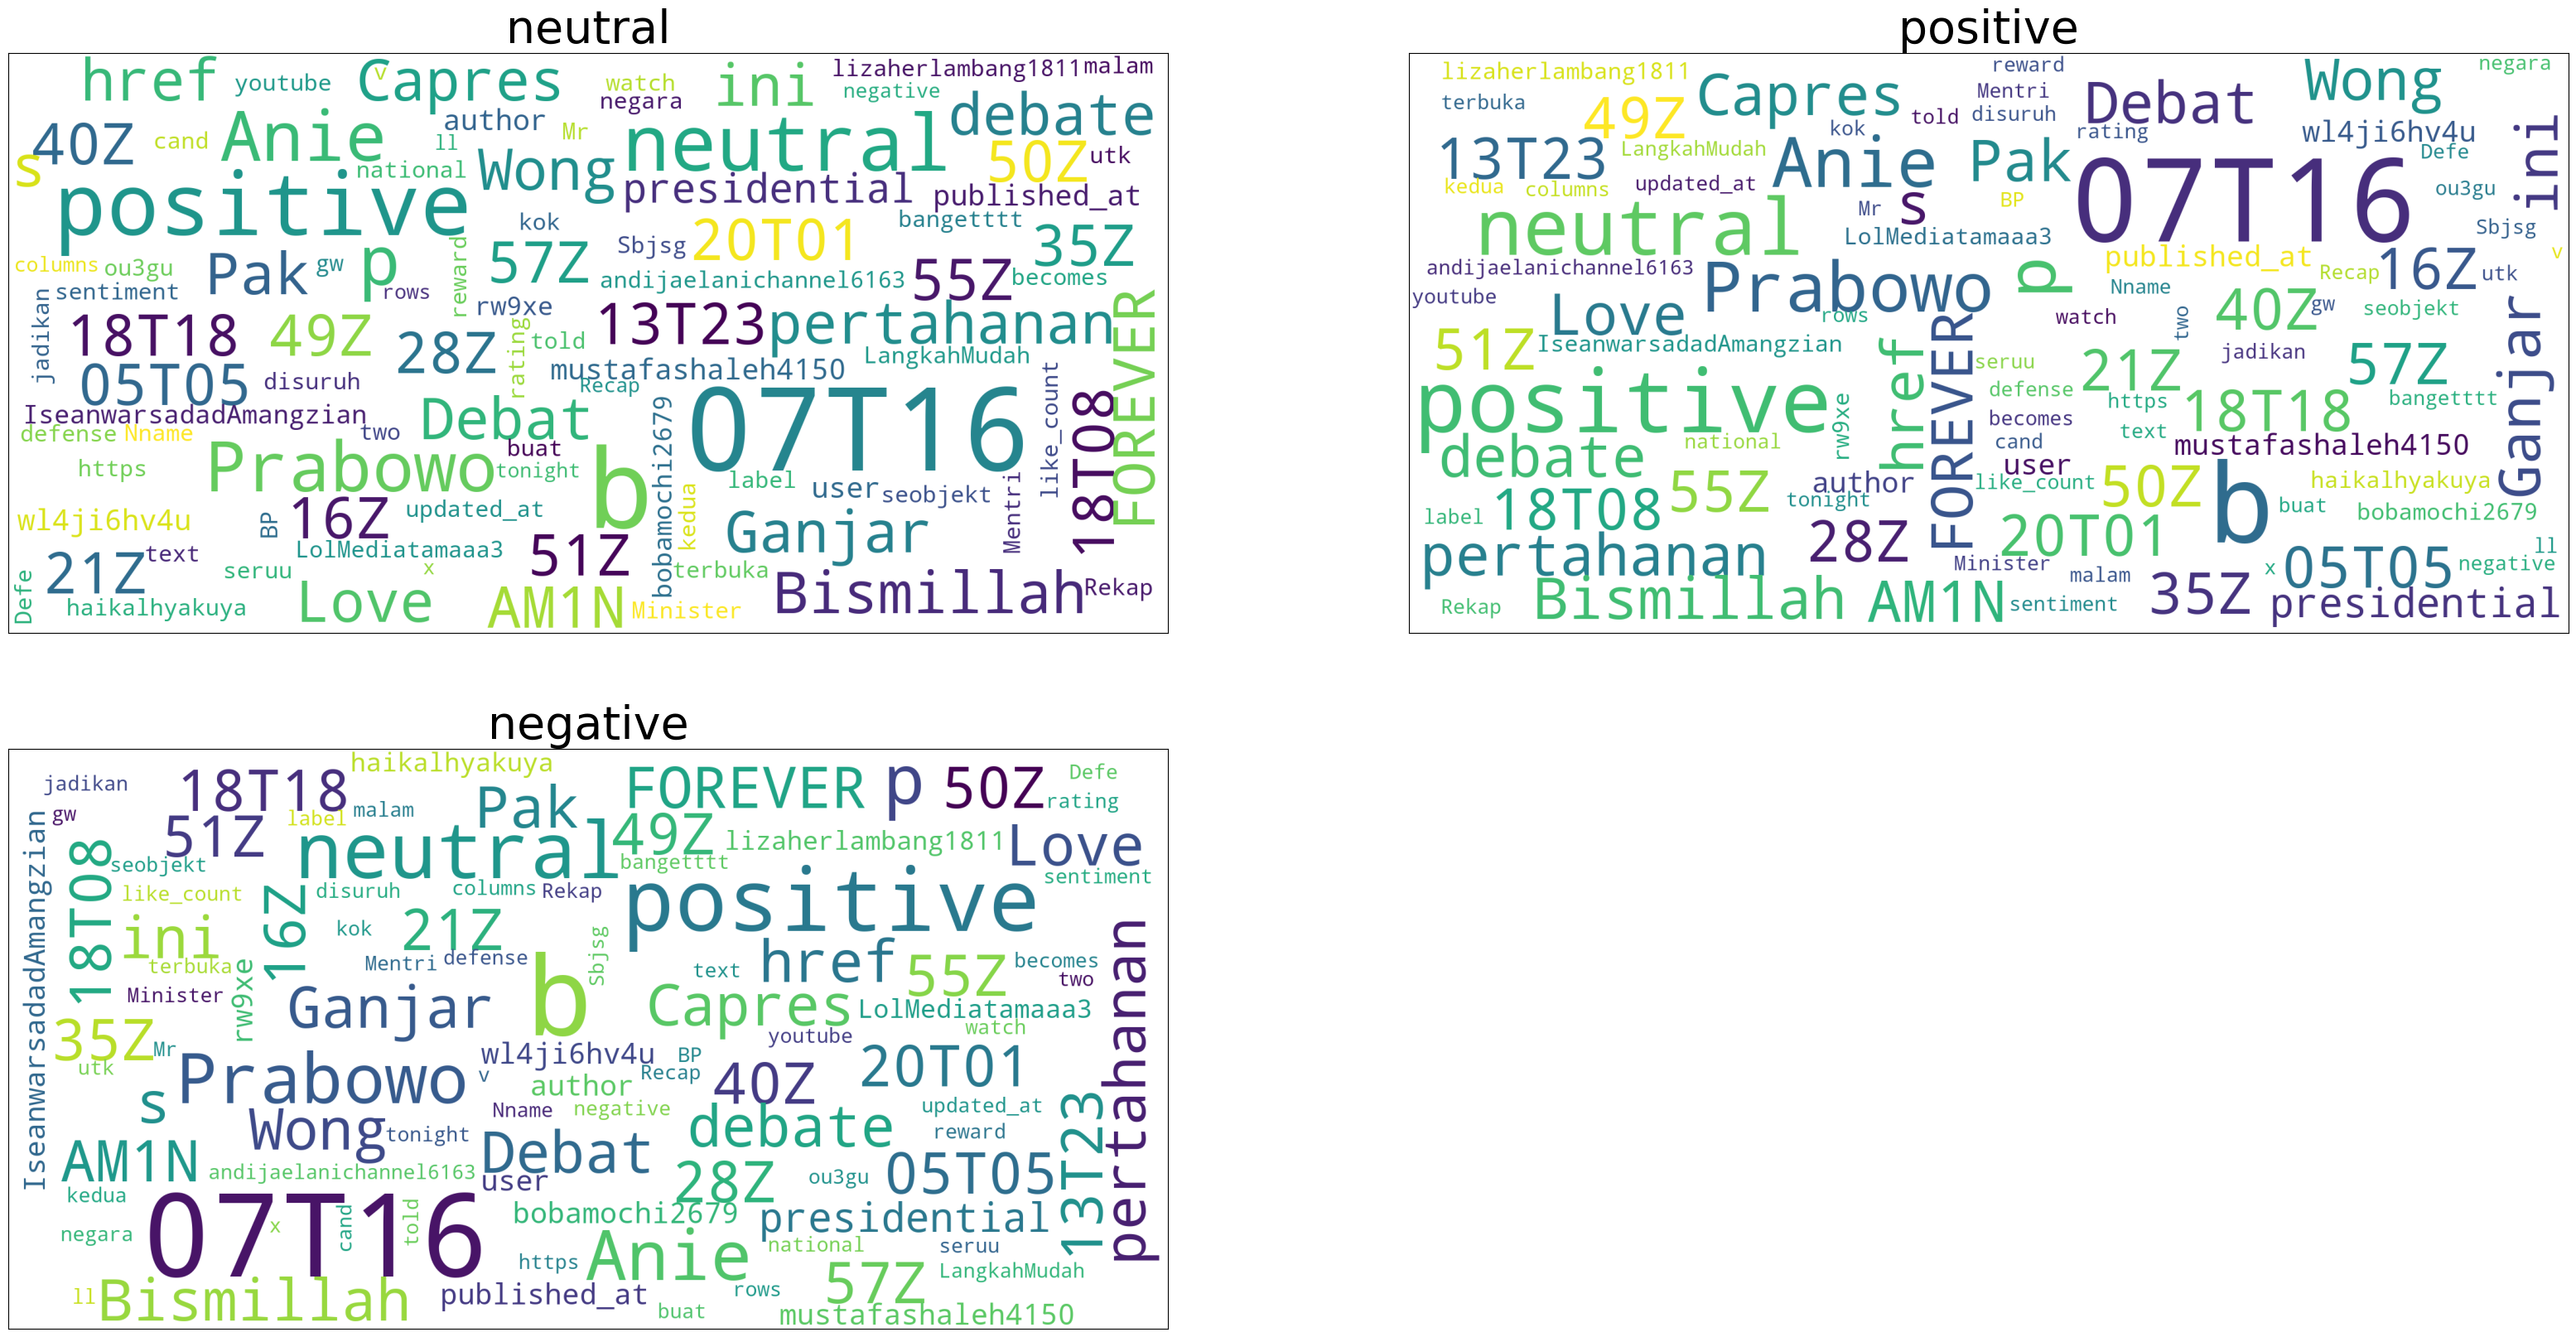

<Figure size 640x480 with 0 Axes>

In [23]:
# plot 2x2 grid word cloud for each sentiment
plt.figure(figsize=(40,20))

for index, col in enumerate(data['sentiment'].unique()):
    plt.subplot(2,2, index+1)
    # print(col)
    df1 = data[data['sentiment']==col]
    data1 = df1['text']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    # fig = plt.figure(figsize=(15,15))
    # plt.axis('off')
    # disable ticks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=40)

plt.show()
plt.tight_layout()

## 7. Analisis Kata Kunci

Bagian ini menggunakan library fuzzywuzzy untuk mencari kata-kata yang menyerupai kata-kata tertentu (dalam contoh ini, "ganjar", "anies", dan "prabowo") dalam kolom 'text'. Fungsi find_typo mencari kata-kata yang memiliki rasio kesamaan di atas ambang batas tertentu (default 80) dengan kata-kata yang dicari.

In [24]:
# # Mencari kata-kata yang menyerupai kata kunci
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Kata-kata yang ingin dicari
words_to_match = ["ganjar", "anies", "prabowo"]

# Fungsi untuk mencari typo
def find_typo(data, column, words_to_match, threshold=80):
    typo_list = []
    for word_to_match in words_to_match:
        for index, row in data.iterrows():
            # Memastikan bahwa data adalah string
            if isinstance(row[column], str):
                ratio = fuzz.ratio(row[column].lower(), word_to_match)
                if ratio >= threshold:
                    typo_list.append((word_to_match, row[column]))
    return typo_list

# Mencari typo dalam kolom 'text'
typo_list = find_typo(data, 'text', words_to_match)

print(typo_list)
count = len(typo_list)
print(count)

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


[('ganjar', 'Ganjar r1'), ('anies', 'Anies❤'), ('anies', 'anies☝️'), ('anies', 'anies 👍'), ('anies', 'anis'), ('anies', 'Anies ❤'), ('anies', 'anis'), ('anies', 'Anis❤'), ('prabowo', 'Prbowo♡'), ('prabowo', 'Prabowo❤'), ('prabowo', 'PRABOWO'), ('prabowo', 'Prabowo❤'), ('prabowo', 'prabowo'), ('prabowo', 'Prabowo \U0001faf6🏼'), ('prabowo', 'Prabowo ❤'), ('prabowo', 'prabowoo'), ('prabowo', 'Prabowo'), ('prabowo', '@prabowo'), ('prabowo', 'KO Prabowo'), ('prabowo', 'praboow'), ('prabowo', 'Prabowo❤'), ('prabowo', 'Prabowo ❤')]
22


## 8. Visualisasi Jumlah Kata Kandidat Capres

### 8.1 Visualisasi Frekuensi Kemunculan Kandidat Capres

Kode ini menghitung jumlah kemunculan kata-kata kunci ("ganjar", "anies", dan "prabowo") dalam kolom 'text', dan memvisualisasikannya menggunakan bar chart.

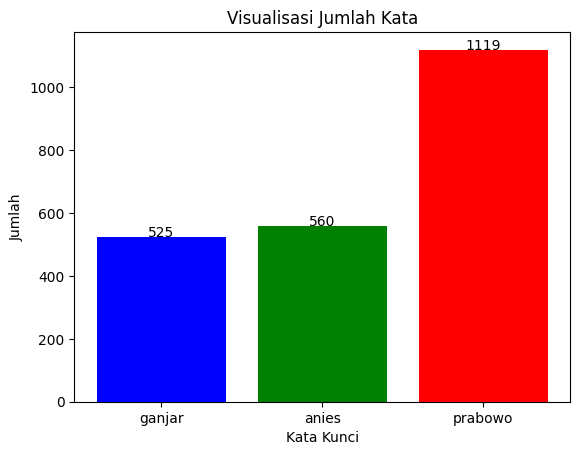

In [25]:
# Kata-kata yang ingin dicari

# Menghitung jumlah kemunculan kata kunci
word_counts = {}

for word in words_to_match:
    # Menghitung berapa kali kata muncul dalam kolom 'text'
    word_counts[word] = data['text'].str.contains(word, case=False, na=False).sum()

words = [word for word in word_counts.keys()]
counts = [word_counts[word] for word in words]

counts_array = np.array(counts)

# Memvisualisasikan jumlah kemunculan kata kunci menggunakan bar chart
plt.bar(words, counts_array, color=['blue', 'green', 'red'])

for i in range(len(words)):
    plt.text(i, counts_array[i], str(counts_array[i]), ha='center')

plt.xlabel('Kata Kunci')
plt.ylabel('Jumlah')
plt.title('Visualisasi Jumlah Kata')
plt.show()


### 8.2 Visualisasi Distribusi Sentimen untuk Kandidat Capres

Bagian ini memvisualisasikan distribusi sentimen ('positif' dan 'negatif') untuk kata-kata kunci ("ganjar", "anies", dan "prabowo") beserta variasi ejaan yang mirip. Untuk setiap kata kunci, dibuat sebuah pie chart yang menunjukkan persentase sentimen positif dan negatif.

In [26]:
# Fungsi untuk mencari typo
def find_typo(data, column, words_to_match, threshold=80):
    typo_dict = {word: [] for word in words_to_match}
    for word_to_match in words_to_match:
        for index, row in data.iterrows():
            ratio = fuzz.ratio(row[column].lower(), word_to_match)
            if ratio >= threshold:
                typo_dict[word_to_match].append(row[column])
    return typo_dict

# Mencari typo dalam kolom 'text'
typo_dict = find_typo(data, 'text', words_to_match)

# Menghitung distribusi sentimen untuk kata kunci dan kata-kata yang mirip
sentiment_counts = {}

for word, similar_words in typo_dict.items():
    # Menggabungkan kata asli dan kata-kata yang mirip
    all_words = [word] + similar_words
    # Mencari frekuensi sentimen dari kata-kata asli dan kata-kata yang mirip
    sentiment_counts[word] = data[data['text'].str.contains('|'.join(all_words), case=False)].groupby('sentiment').size()

print(sentiment_counts)

{'ganjar': sentiment
negative     88
neutral      69
positive    368
dtype: int64, 'anies': sentiment
negative    293
neutral     245
positive    747
dtype: int64, 'prabowo': sentiment
negative    259
neutral     263
positive    600
dtype: int64}


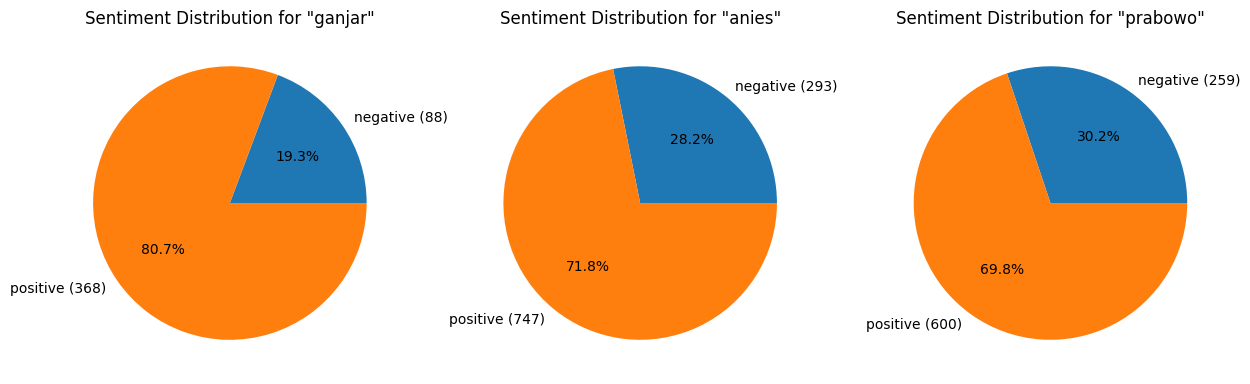

In [27]:
# Memvisualisasikan distribusi sentimen untuk setiap kata kunci menggunakan pie chart
fig, axs = plt.subplots(1, len(sentiment_counts), figsize=(15,6))

for ax, (word, sentiment_count) in zip(axs, sentiment_counts.items()):
    # Hanya ambil sentimen 'positive' dan 'negative'
    sentiment_count = sentiment_count[sentiment_count.index.isin(['positive', 'negative'])]

    ax.pie(sentiment_count, labels=[f'{label} ({count})' for label, count in zip(sentiment_count.index, sentiment_count)], autopct='%1.1f%%')
    ax.set_title(f'Sentiment Distribution for "{word}"')

plt.show()

### 8.3 Visualisasi Jumlah Sentimen Positif dan Negatif untuk Kandidat Capres

Kode ini memvisualisasikan jumlah sentimen positif dan negatif untuk kata-kata kunci ("ganjar", "anies", dan "prabowo") menggunakan bar chart.

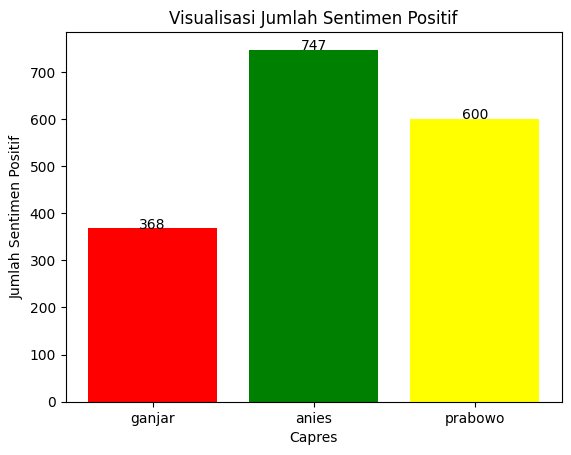

In [28]:

# Membuat list dari kata kunci dan jumlah sentimen positif
words = [word for word in sentiment_counts.keys()]
positive_counts = [sentiment_counts[word]['positive'] for word in words]

# Membuat array dari jumlah sentimen positif
counts = np.array(positive_counts)

# Membuat bar plot dengan warna yang berbeda untuk setiap bar
colors = ['red', 'green', 'yellow']
plt.bar(words, counts, color=colors)

# Menambahkan angka di atas setiap bar
for i in range(len(words)):
    plt.text(i, counts[i], str(counts[i]), ha='center')

plt.xlabel('Capres')
plt.ylabel('Jumlah Sentimen Positif')
plt.title('Visualisasi Jumlah Sentimen Positif')
plt.show()

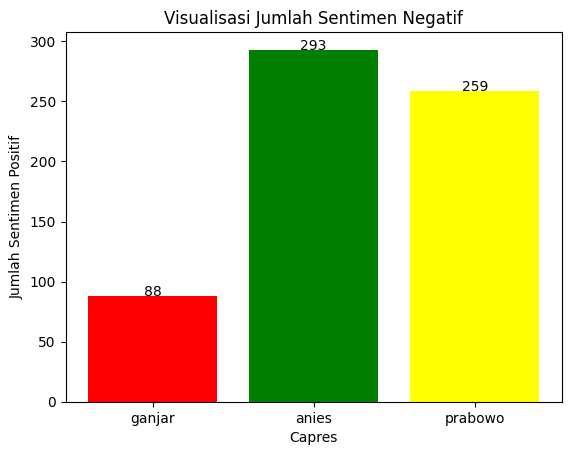

In [29]:
# Membuat list dari kata kunci dan jumlah sentimen Negatif
words = [word for word in sentiment_counts.keys()]
positive_counts = [sentiment_counts[word]['negative'] for word in words]

# Membuat array dari jumlah sentimen positif
counts = np.array(positive_counts)

# Membuat bar plot dengan warna yang berbeda untuk setiap bar
colors = ['red', 'green', 'yellow']
plt.bar(words, counts, color=colors)

# Menambahkan angka di atas setiap bar
for i in range(len(words)):
    plt.text(i, counts[i], str(counts[i]), ha='center')

plt.xlabel('Capres')
plt.ylabel('Jumlah Sentimen Positif')
plt.title('Visualisasi Jumlah Sentimen Negatif')
plt.show()


## 9. Preprocessing Lanjutan

Bagian ini melakukan pemrosesan teks dengan membersihkan teks dari karakter non-alfanumerik, menghapus stopwords, dan melakukan stemming. Fungsi preprocess melakukan semua tugas ini dan diterapkan pada kolom 'text' dalam dataset.

In [30]:
# Membuat stemmer dan stopword remover untuk pemrosesan teks
factory_stem = StemmerFactory()
stemmer = factory_stem.create_stemmer()
factory_stop = StopWordRemoverFactory()
stopword = factory_stop.create_stop_word_remover()

def preprocess(text):
    # Pembersihan data
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'^b\s+', '', text)
    text = text.lower()

    # Tokenisasi
    text = word_tokenize(text)

    # Stopword removal
    text = stopword.remove(' '.join(text))

    # Stemming
    text = stemmer.stem(text)

    return text


data['text'] = data['text'].apply(preprocess)


<ipython-input-30-ffd3ed6a81be>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(preprocess)


In [31]:
data.sample(5)

,author,published_at,updated_at,like_count,text,label,sentiment
3729,@lexsydwy1165,2024-01-07T18:31:12Z,2024-01-07T18:31:12Z,2.0,penting prabowo joget mak tiktok mengidolkan s...,b It s important that Prabowo dances to idoliz...,positive
4377,@aculay8872,2024-01-07T16:51:38Z,2024-01-07T16:51:38Z,0.0,kalo prabowo tabrak nabrak demokrasi kutak ati...,b If Prabowo hadn t crashed democracy and tamp...,positive
2989,@afriadiyus7794,2024-01-07T23:35:09Z,2024-01-07T23:35:09Z,1.0,pak anis hebat,b Mr Anis is great,positive
1762,@sadiahdiah7026,2024-01-08T10:13:49Z,2024-01-08T10:13:49Z,0.0,siapa presiden br yg aku harap sulit lowong ke...,b Whoever the president is br What I hope is t...,positive
3422,@agus11agus67,2024-01-07T19:49:12Z,2024-01-07T19:49:12Z,0.0,pak prabowo takut dgn tanya wkwk pak anis the ...,Pak Prabowo is afraid of questions wow Pak ANI...,positive


## 10. Pembuatan Model Machine Learning

Kode ini membuat model machine learning untuk melakukan klasifikasi sentimen pada teks. Data dibagi menjadi set latih dan set uji menggunakan train_test_split. Kemudian, model pipeline dibuat dengan TfidfVectorizer untuk mengekstrak fitur dari teks dan RandomForestClassifier untuk melakukan klasifikasi. Model dilatih pada set latih, dan performa model dievaluasi pada set uji dengan mengukur akurasi, membuat laporan klasifikasi, dan memvisualisasikan confusion matrix.

In [32]:
# Membagi data menjadi set latih dan set uji
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['sentiment'], test_size=0.2, random_state=42)

In [33]:
# Memeriksa ukuran set latih dan set uji
X_train.shape, X_test.shape

((3736,), (935,))

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ubah set stopwords menjadi list
stopwords_list = list(stopwords)

# Membuat model pipeline dengan TfidfVectorizer dan RandomForestClassifier
clf = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords_list)),
                ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))])

# Melatih model
clf.fit(X_train, y_train)

# Membuat prediksi pada set uji
predictions = clf.predict(X_test)

# Mencetak skor akurasi
print("Accuracy:", accuracy_score(y_test, predictions))




/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


Accuracy: 0.6748663101604279


In [35]:
# Mencetak laporan klasifikasi
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.74      0.17      0.27       208
     neutral       0.65      0.71      0.68       240
    positive       0.68      0.87      0.77       487

    accuracy                           0.67       935
   macro avg       0.69      0.58      0.57       935
weighted avg       0.69      0.67      0.63       935



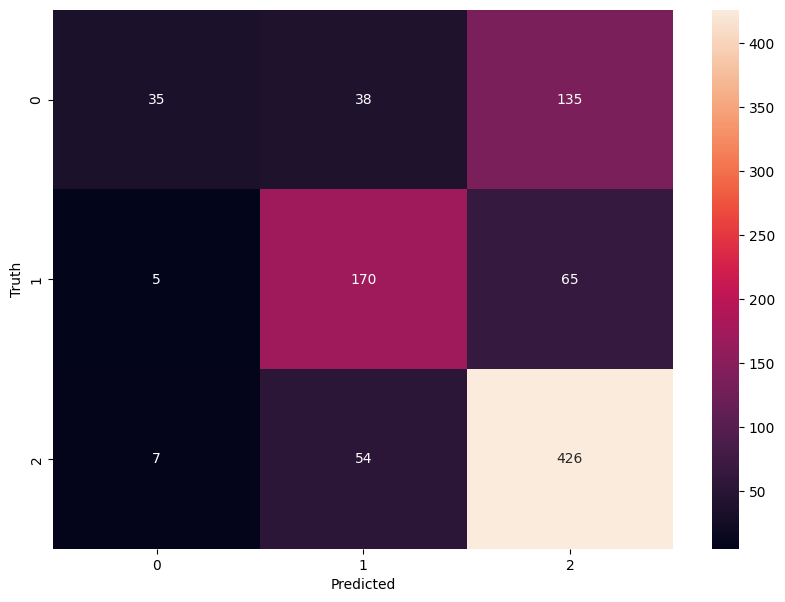

In [36]:
# Membuat confusion matrix
cm = confusion_matrix(y_test, predictions)

# Membuat plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## 11. Menyimpan Model

Kode ini menyimpan model yang telah dilatih ke dalam file debat_sentiment.pkl menggunakan library pickle.

In [37]:
# save model
pickle.dump(clf, open('debat_sentiment.pkl', 'wb'))